In [1]:
import problem_1 as mz
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

# Problem 1 : The Maze and the Random Minotaur


For some unknown reasons you wake up inside a maze (shown in figure 1) in position A. At the same time, there is a minotaur at the exit, in B. The minotaur follows a random walk while staying within the limits of the maze, and can walk inside the walls. This means that for example, if the minotaur is not in a cell at one of the borders of the maze, then it moves to the cell above, below, on the right, and on the left with the same probability 1/4. You cannot walk inside walls, and at a given cell, you may decide to move to an adjacent cell or to stay still. At each step, you observe the position of the minotaur, and decide on a one-step move (up, down, right or left) or not to move. If the minotaur catches you, it will eat you.3 Your objective is to identify a strategy maximizing the probability of exiting the maze (reaching B) before time T.

_Note 1: Neither you nor the minotaur can walk diagonally._

_Note 2: The minotaur catches you, if and only if, you are located at the same position, at the same time._

## Basic Maze

In [2]:
# Question - A

# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]
])
# with the convention
# 0 = empty cell
# 1 = obstacle
# 2 = exit of the Maze

# mz.draw_maze(maze)

# Create an environment maze
env = mz.Maze(maze)

## Dynamic programming

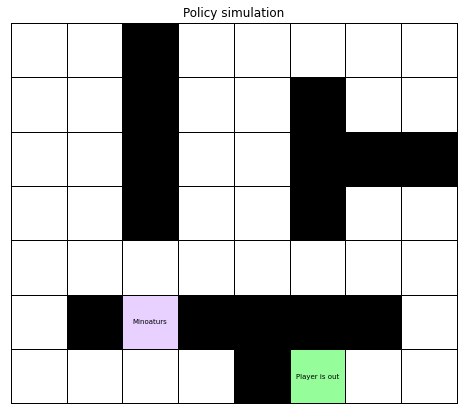

In [7]:
# Question - B

# Finite horizon
horizon = 20

# Solve the MDP problem with dynamic programming 
V, policy, minotaurs_path = mz.dynamic_programming(env,horizon,True);


# Simulate the shortest path starting from position A
method = 'DynProg';
start  = (0,0);
path,_ = env.simulate(start, policy, method);
mz.animate_solution(maze,path,minotaurs_path)

In [ ]:
# Question - C 

H_list=[]
P_list_stay=[]
P_list_not_stay=[]
p=1000

for horizon in range(31):
    d_mcm0, _ = mz.monte_carlo_method(p=p,start=start,maze=maze,horizon=horizon,env=env,method=method,minotaurs_stay=True)
    if len(d_mcm0) > 1:
        P_list_stay.append(100*d_mcm0[0]/(d_mcm0[0]+d_mcm0[1]))
    else:
        P_list_stay.append(100)
    d_mcm0, _ = mz.monte_carlo_method(p=p,start=start,maze=maze,horizon=horizon,env=env,method=method,minotaurs_stay=False)
    if len(d_mcm0) > 1:
        P_list_not_stay.append(100*d_mcm0[0]/(d_mcm0[0]+d_mcm0[1]))
    else:
        P_list_not_stay.append(100)
    
    H_list.append(horizon)



In [ ]:

fig, ax = plt.subplots()
ax.plot(H_list, P_list_stay, label='Stay', c='r', lw=2)
ax.plot(H_list, P_list_not_stay, label='Not Stay', c='g', lw=2)
ax.set_title('Probability of leaving the maze for several time horizon')
ax.set_xlabel('Horizon')
ax.set_ylabel('Probability of exiting the maze (in %)')
ax.grid(True)
ax.legend()
plt.savefig('fig_question_C')


## Value Iteration

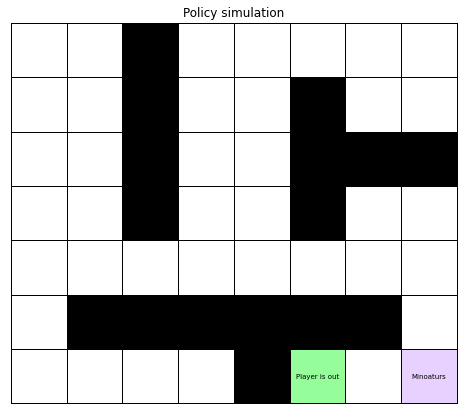

In [8]:
# Question - D

discount_factor = 29/30
epsilon = 0.0001
V, policy = mz.value_iteration(env,discount_factor, epsilon)
path, _ = env.simulate((0,0), policy, 'ValIter', life_0 = mz.starting_life(30))
mz.animate_solution(maze,path,mz.randomize_minotaur_path(start = (6,5), maze_dimensions = maze.shape, T = len(path)-1))


In [ ]:
V[env.map[start]]

In [ ]:
# Question - E

p = 10000
exiting = 0
GEOM = np.random.geometric(p=1-discount_factor, size=p)

for i in range(p):
    path, _ = env.simulate((0,0), policy, 'ValIter', life_0 = mz.starting_life(30))
    if GEOM[i] > len(path) or path[GEOM[i]-1] == 'WIN' or (path[GEOM[i]-1][0] == (6,5) and path[GEOM[i]-1][1] != (6,5)):
        #Every possibility that means that the player has won the game
        exiting += 1
print(f"Probability of exiting the maze is {exiting/p} \n")


In [ ]:
# Question G

# add the intermidiate state - C
mazeC, mazeB = maze.copy(), maze.copy()
mazeC[6,5], mazeC[0,7], mazeB[0,7] = 0, 2, -2
envC, envB = mz.Maze(mazeC), mz.Maze(mazeB)

discount_factor, epsilon, life_0 = 0.99, 0.0001, mz.starting_life(50)

_, policyC = mz.value_iteration(envC,discount_factor, epsilon)

pathC, life_felft = envC.simulate((0,0), policyC, 'ValIter', life_0)
if(life_felft>0 and pathC[-1]==(0,7)):

    _, policyB = mz.value_iteration(envB,discount_factor, epsilon)
    pathB, life_felft = envB.simulate(pathC[-1], policyB, 'ValIter',life_0 = life_felft)    

    if (life_felft>0 and pathB[-1]==(6,5)):

        pathA = pathC[:-2]+pathB

        minotaurs_path = [(6,5)]
        for t in range(len(pathA)):
            if random.uniform(0,1) < 0.65:
                move = mz.randomize_minotaur_path(start = minotaurs_path[-1], maze_dimensions = maze.shape, T = 1)[1]
            else:
                move = mz.orientated_minotaur_path(start = minotaurs_path[-1], goal = np.array(pathA[t]), T = 1)

            minotaurs_path.append(move)   
        
        mz.animate_solution(mazeB,pathA,minotaurs_path)
        print(f"Initial life of {life_0} is enough to get the key and to leave the Maze")
        
    else:
        print(f"Initial life of {life_0} is not enough to leave the Maze")
else:
    print(f"Initial life of {life_0} is not enough to take the key")



## Q-Learning

In [ ]:
# Question H-2 and # Question H-3

mazeC, mazeB = maze.copy(), maze.copy()
mazeC[6,5], mazeC[0,7], mazeB[0,7] = 0, 2, -2
envC, envB = mz.Maze(mazeC), mz.Maze(mazeB)

epsilon = 0.5
discount_factor = 0.8
alpha = 2/3
algotithm = "Q-Learning"

fig, ax = plt.subplots()

Q_c_qlearning, policy_qlearning_C = mz.q_learning_or_sarsa(envC, discount_factor, epsilon=epsilon, alpha=alpha, algorithm = algotithm, start = (0,0), axes=ax)
Q_b_qlearning, policy_qlearning_B = mz.q_learning_or_sarsa(envB, discount_factor, epsilon=epsilon, alpha=alpha, algorithm = algotithm, start = (0,7), axes=ax)

plt.grid(axis = 'y')
plt.title(f'Evolution of the Value Function over episodes with Q - Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of the value function')
plt.legend(('Start   ->   Key','Key     ->   Exit'))
plt.show()

In [ ]:
print(mz.f(policy_qlearning_B))

In [ ]:
# Question I-2 and # Question I-3

mazeC, mazeB = maze.copy(), maze.copy()
mazeC[6,5], mazeC[0,7], mazeB[0,7] = 0, 2, -2
envC, envB = mz.Maze(mazeC), mz.Maze(mazeB)

epsilon = 0.2
discount_factor = 0.8
alpha = 2/3
algotithm = "SARSA"

fig, ax = plt.subplots()

Q_c_sarsa, policy_sarsa_C = mz.q_learning_or_sarsa(envC, discount_factor=discount_factor, epsilon=epsilon, alpha=alpha, algorithm = algotithm, start = (0,0), axes=ax, Q = np.zeros(shape=(40,5)))
Q_b_sarsa, policy_sarsa_B = mz.q_learning_or_sarsa(envB, discount_factor=discount_factor, epsilon=epsilon, alpha=alpha, algorithm = algotithm, start = (0,7), axes=ax, Q = np.zeros(shape=(40,5)))

plt.grid(axis = 'y')
plt.title(f'Evolution of the Value Function over episodes with SARSA')
plt.xlabel('Episodes')
plt.ylabel('Sum of the value function')
plt.legend(('Start   ->   Key','Key     ->   Exit'))
plt.show()

In [ ]:
print(mz.f(policy_sarsa_C))

In [ ]:
# Test of path for Q learning and Sarsa

start = (0,0)
key = (0,7)
exit = (6,5)

P_exit_qlearning = []
P_exit_sarsa = []
horizon = []

# policy_qlearning_C, policy_sarsa_C = policyC, policyC
# policy_qlearning_B, policy_sarsa_B = policyB, policyB

probability = lambda d: 100*d[0]/(d[0]+d[1]+d[2]) if d[0]!=0 else 0


for life_0 in range(0, 51):    # for each life
    
    d_results_qlearning = {0:0,1:0,2:0}
    d_results_sarsa = {0:0,1:0,2:0}


    for h in range(100):       # Try 100 times for eaach life

        # Run minotaur
        minotaurs_path = mz.randomize_minotaur_path(start = exit, maze_dimensions = maze.shape, T = life_0+1)

        # Q-Learning
        pathC, life_felft = envC.simulate(start, policy_qlearning_C, 'ValIter', life_0 = life_0)
        
        if(life_felft>0 and pathC[-1]==key):
            pathB, life_felft = envB.simulate(pathC[-1], policy_qlearning_B, 'ValIter',life_0 = life_felft)    

            if (life_felft>0 and pathB[-1]==exit):

                pathA = pathC[:-2]+pathB  

                d_results_qlearning[
                    mz.path_result(pathA,minotaurs_path,tuple(exit))
                ] += 1

        # Q-SARSA
        pathC, life_felft = envC.simulate(start, policy_sarsa_C, 'ValIter', life_0 = life_0)
        
        if(life_felft>0 and pathC[-1]==key):
            pathB, life_felft = envB.simulate(pathC[-1], policy_sarsa_B, 'ValIter',life_0 = life_felft)    

            if (life_felft>0 and pathB[-1]==exit):

                pathA = pathC[:-2]+pathB  

                d_results_sarsa[
                    mz.path_result(pathA,minotaurs_path,tuple(exit))
                ] += 1

    # store the probabilities
    P_exit_qlearning.append(probability(d_results_qlearning))
    P_exit_sarsa.append(probability(d_results_sarsa))
    horizon.append(life_0)
                

In [ ]:
fig, ax = plt.subplots()
ax.plot(horizon, P_exit_qlearning, label='Q-Learning', c='r', lw=2)
ax.plot(horizon, P_exit_sarsa, label='SARSA', c='g', lw=2)
ax.set_title('Probability of leaving the maze for different policies')
ax.set_xlabel('Horizon')
ax.set_ylabel('Probability of exiting the maze (in %)')
ax.grid(True)
ax.legend()
plt.savefig('fig_question_i')